In [3]:
import cantera as ct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


crit_paths_only3
species 83
rxns 198
Cycle 10
1.319329023361206
Cycle 25
3.1109468936920166
Cycle 50
6.134472846984863
Cycle 100
12.253412961959839
Cycle 500
60.998400926589966
Cycle 750
91.55614590644836
121.99392104148865


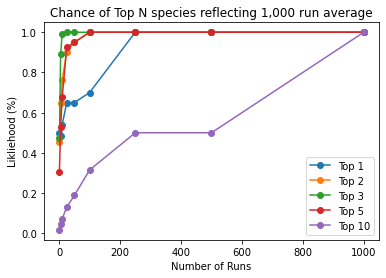

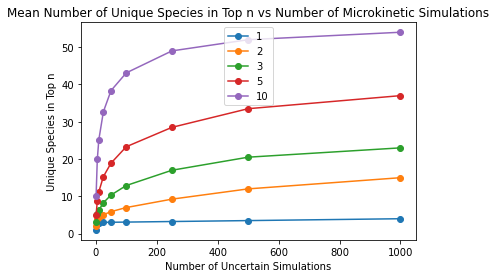

In [4]:
# generater excel spreadsheet of results
num= 15
new = ["un_no_0", "un_no_1", "un_no_2", "un_no_3", "un_no_4", "un_no_5", "un_no_6", "un_no_7", "un_no_8", "un_no_9", "un_no_10", "un_no_11", "un_no_12", "un_no_13", "un_no_14", "un_no_15", "un_no_16", "un_no_17","un_no_18", "un_no_19"]
new = ["crit_paths_only3"]
# new = ["un_no_19"]
# new = ["un_no_0", "un_no_1", "un_no_2"]
for name in new:
    print(name)
#     path to yaml files
#     yaml_file= f'/Users/mwoulfe/Documents/Research/Cantera_Glucose/uncertainty_re_explore/{name}.yaml'
    yaml_file= f'/Users/mwoulfe/Documents/Research/Cantera_Glucose/yamls/glucose/{name}.yaml'
    
#     create gas solution
    gas = ct.Solution(yaml_file)
    r = ct.IdealGasConstPressureReactor(contents=gas, energy='off', name='isothermal_reactor')
    sim = ct.ReactorNet([r])
    states = ct.SolutionArray(gas, extra=['t'])

    species = states.species_names
    rxns = gas.reactions()
    print("species",len(species))
    print("rxns", len(rxns))

    
    # Sim timeframe
    start_t = time.time()
    cycles = 1000
    top_n = 10
    dt_max = .1  #secs
    n_steps = 1200 
    tot_time = n_steps * dt_max
    conv = 4184000 # conv 1 kcal/mol = 4184000 j/kmol # default Cantera E units is J/kmol
    scale = 2.25 *conv  # 95% of errors will be within 3 kcal/mol when scale = 1.5 * conv
                       # 2.25 --> will be within 4.5 kcal/mol difference (conformational and dft errors combined)

    sim.verbose = True

    # track number of top six (h2o) net fluxes, flux stats, mass percents stats (max, min, median, mean)
    
    mass_percents, barriers, concentrations = [], [], []
    flux_step0, rxn_fluxes = [], []
    fluxes = []
    cycle_print = [10, 25, 50, 100, 500, 750, 1000]
    for i in range(cycles):
        if i in cycle_print: 
            print(f"Cycle {i}")
            print(time.time()-start_t)

    #     initialize system from yaml
        gas = ct.Solution(yaml_file)

        # implement gaussian noise to change rxns
        noise = np.random.normal(0,scale,len(rxns))
        temp = {}
        sim_bar = []
        # update bariers
        for c,v in enumerate(gas.reactions()):
            temp = rxns[c].input_data
            temp['rate-constant']['Ea'] = (rxns[c].rate.activation_energy + noise[c])
            gas.modify_reaction(c, ct.Reaction.from_dict(temp, kinetics = gas))
            sim_bar.append(temp['rate-constant']['Ea']/conv)
            
        # confirm barriers are updated
    #     for c,v in enumerate(gas.reactions()[:4]):  
    #         print(f"New:      {v} \t\tEa: {(gas.reactions()[c].rate.activation_energy/conv)}")
    #         print(f"Original: {v} \t\tEa: {(rxns[c].rate.activation_energy)/conv}")

        # update reactor/states
        r = ct.IdealGasConstPressureReactor(contents=gas, energy='off', name='isothermal_reactor')
        sim = ct.ReactorNet([r])
        states = ct.SolutionArray(gas, extra=['t'])

        ######## run simulation #############
        states.append(r.thermo.state, t=sim.time)
        while sim.time <= tot_time:
            sim.advance(sim.time + dt_max)
            states.append(r.thermo.state, t=sim.time)

        ######### analysis ###########
        spe_net_step0 = np.trapz(states.net_production_rates, dx=dt_max, axis=0) # for initial step only (1st step dominates all successive steps)
        spe_net = np.trapz(states.net_production_rates[1:], dx=dt_max, axis=0) # for explor policy/later steps
        rxn_net = np.trapz(states.net_rates_of_progress, dx=dt_max, axis=0)

        # test data analysis stuff
        all_states = states.Y[-1,:]
        concentrations.append(states.X[-1,:])
        mass_percents.append(all_states)
        flux_step0.append(spe_net_step0) # if I want from step 1, just ignore first row of df
        fluxes.append(spe_net)
        rxn_fluxes.append(rxn_net)
        barriers.append(sim_bar)

    print(time.time()-start_t)
    
    flux_step0_df = pd.DataFrame(flux_step0, columns=species)
    fluxes_df = pd.DataFrame(fluxes[:], columns=species)
    rxn_fluxes_df = pd.DataFrame(rxn_fluxes, columns=rxns)
    mass_df = pd.DataFrame(mass_percents, columns=species)
    barrier_df = pd.DataFrame(barriers, columns=rxns)
    conc_df = pd.DataFrame(concentrations, columns=species)
    
    mean_values = fluxes_df.mean()
    ranked_mean = mean_values.sort_values(ascending=False).index.tolist()
    
    
#     # find ranked mean ordering
#     print("Ranked_Mean")
#     for i in ranked_mean[:num]:
#         print(f"{i:<25} Flux: {mean_values[i]:.20f}")
# #         print(i, mean_values[i])
#     print('\n')
#     for i in ranked_mean[:num]:
#         print(f"{i}")
   
    # find how many species appear in top five
    if name == "un_no_0": df_t = flux_step0_df
    else: df_t = fluxes_df

    # Runs to consider
    runs_to_consider = [1, 5, 10, 25, 50, 100, 250, 500, 1000]#, 2500, 5000]
#     runs_to_consider = [10, 25, 50, 100]
    runs_max = df_t.shape[0] # total number of runs

    # Top N positions to check
    top_ns = [1, 2, 3, 5, 10]
    # top_ns = [5]

    # Initialize a nested dictionary to store results; first keyed by top N, then by number of runs
    results = {n: {num_runs: 0 for num_runs in runs_to_consider} for n in top_ns}
    smiles_counts_dict = {n: {num_runs: 0 for num_runs in runs_to_consider} for n in top_ns}
    # Iterate through the specified top N values
    for n in top_ns:

        # Then iterate through the specified numbers of runs
        for num_runs in runs_to_consider:

    #         print("num_runs", num_runs, '\n', 'n', n)

            if runs_max % num_runs == 0:
                mean_list, ts_list= [], []
                for start in range(0, len(df_t), num_runs):
                    end = start + num_runs
                    df_subset = df_t[start:end]

                    # get mean values of subset dataframe and add smiles of top n to top_species_list
                    top_n_species = df_subset.mean().sort_values(ascending=False).head(n).index.tolist()
                    ts_list.append(top_n_species)

                    df_subset_t = df_subset.T
                    unique_species = set()

                    # get cumulative list of top species across all runs in subset dataframe
                    for col in df_subset_t.columns:
                        top_species = df_subset_t[col].nlargest(n).index
                        unique_species.update(top_species)
                    mean_list.append(len(unique_species))

    #                 if num_runs == 100: 
    #                     print(len(unique_species))
    #                     print(len(mean_list), sum(mean_list), mean_list)

                # flatten the top_species list of lists
                flat_list = [smiles for sublist in ts_list for smiles in sublist]

                # count occurrences in new list
                smiles_counts = {}
                for smiles in flat_list:
                    if smiles in smiles_counts:
                        smiles_counts[smiles] += 1
                    else:
                        smiles_counts[smiles] = 1
    #             for k, v in smiles_counts.items():
    #                 print(k,v)
    #             print("values_sum", sum(smiles_counts.values()))
    #             print('\n')
                smiles_counts_dict[n][num_runs] = smiles_counts    
                results[n][num_runs] = sum(mean_list)/len(mean_list)

            else:
                ts_list = []
                # Slice the DataFrame to consider only the first num_runs runs
                df_subset = df_t.iloc[:num_runs, :]

                # get mean values of subset dataframe and add smiles of top n to top_species_list
                top_n_species = df_subset.mean().sort_values(ascending=False).head(n).index.tolist()
                ts_list.append(top_n_species)

                # Transpose the subset to work with species as rows
                df_subset_t = df_subset.T

                # Set to hold all unique species appearing in the top N across the considered runs
                unique_species = set()

                # Iterate through each column (run) in the subset and update the set with the top N species
                for col in df_subset_t.columns:
                    top_species = df_subset_t[col].nlargest(n).index
                    unique_species.update(top_species)

                # flatten the list of lists
                flat_list = [smiles for sublist in ts_list for smiles in sublist]

                # count occurrences
                smiles_counts = {}
                for smiles in flat_list:
                    if smiles in smiles_counts:
                        smiles_counts[smiles] += 1
                    else:
                        smiles_counts[smiles] = 1

                # Update the results dictionary with the count of unique species for this top N and number of runs
                results[n][num_runs] = len(unique_species)


    # generate dict of top n smiles and percentage of time in top n
    exp_step_dict = {}
#     print(smiles_counts_dict.items(), '\n')
    for k, inner_dict in smiles_counts_dict.items():
    #     print(type(list(inner_dict[1000].keys())))
#         print(k, inner_dict, '\n')
        new_dict = {}
        for count, smile in enumerate(list(inner_dict[max(runs_to_consider)].keys())):
    #         print(smile)
            smile_appear = []
            for key, in_in_dict in inner_dict.items():
#                 print(k, in_in_dict)
                try:
                    percent = in_in_dict[smile]/ (cycles/ float(key))
                except KeyError:
                    percent = 0
#                 print(percent)
                smile_appear.append(percent)
                new_dict[smile] = smile_appear
    #             new_dict[f"species {count+1}"] = smile_appear
        exp_step_dict[k] = new_dict
        
#     print(exp_step_dict, '\n')

    result = {}

    # calculate percentage of top n smiles all present
    for sim_id, smiles_dict in exp_step_dict.items():
        product_result = {}
        for smiles, values in smiles_dict.items():
    #         print(smiles, values)
            if sim_id not in result:
                result[sim_id] = [1] * len(values)  # Initialize with 1 for multiplication
            # Multiply corresponding indices
            result[sim_id] = [prev_val * curr_val for prev_val, curr_val in zip(result[sim_id], values)]
            
            
    exp_step_df = pd.DataFrame.from_dict(exp_step_dict, orient='index')
    result_df = pd.DataFrame(result)
    results_df = pd.DataFrame.from_dict(results, orient='index')
    
    # write dataframes to excel sheet to avoid rerunning
#     with pd.ExcelWriter(f"Glu_net_error_spreadsheets/{name}_output2.xlsx") as writer:
#     with pd.ExcelWriter(f"Glu_net_error_spreadsheets/{name}_output_4-5kcal2.xlsx") as writer:
#         result_df.to_excel(writer,sheet_name='chance of all top n present')    
#         results_df.to_excel(writer,sheet_name='num unique species')    
#         exp_step_df.to_excel(writer,sheet_name='individual chance top n present')
#         if 'un_no_0' in name: flux_step0_df.to_excel(writer,sheet_name='fluxes')
#         else: fluxes_df.to_excel(writer,sheet_name='fluxes')
#         rxn_fluxes_df.to_excel(writer,sheet_name='rxn_fluxes')    
#         mass_df.to_excel(writer,sheet_name='final_mass')    
#         conc_df.to_excel(writer,sheet_name='final_concentration')    
#         barrier_df.to_excel(writer,sheet_name='barriers')
        
    
#     plottting

    # Generate x-values based on the length of the first series
    x_values = runs_to_consider

    # Plotting each series
    for key, y_values in result.items():
        plt.plot(x_values, y_values, label=f'Top {key}',marker='o')

    # Adding legend
    plt.legend()

    # Adding title and axis labels
    plt.title('Chance of Top N species reflecting 1,000 run average')
    plt.xlabel('Number of Runs')
    # plt.xscale('log')

    plt.ylabel('Likliehood (%)')

    # Display the plot
    plt.show()

    for label, inner_dict in results.items():
        x = list(inner_dict.keys())
        y = list(inner_dict.values())
        plt.plot(x, y, label=label, marker='o')

    # Adding legend
    plt.legend()

    # Adding title and labels
    plt.title('Mean Number of Unique Species in Top n vs Number of Microkinetic Simulations')
    plt.xlabel('Number of Uncertain Simulations')
    # plt.xscale('log')
    plt.ylabel('Unique Species in Top n')

    # Display the plot
    plt.show()

In [ ]:
# uncertainty kinetics. Analyze results
new = ["un_no_1", "un_no_3", "un_no_7", "un_no_11", "un_no_15", "un_no_19" ]
rest = ["un_no_2", "un_no_4", "un_no_5", "un_no_6", "un_no_8", "un_no_9", "un_no_10", "un_no_12", "un_no_13", "un_no_14", "un_no_16", "un_no_17","un_no_18" ]
num= 15
new = ["un_no_0", "un_no_1", "un_no_2", "un_no_3", "un_no_4", "un_no_5", "un_no_6", "un_no_7", "un_no_8", "un_no_9", "un_no_10", "un_no_11", "un_no_12", "un_no_13", "un_no_14", "un_no_15", "un_no_16", "un_no_17","un_no_18", "un_no_19"]
for name in new:
    print(name)
#     path to yaml files
    yaml_file= f'/Users/mwoulfe/Documents/Research/Cantera_Glucose/uncertainty_re_explore/{name}.yaml'
    
#     create gas solution
    gas = ct.Solution(yaml_file)
    r = ct.IdealGasConstPressureReactor(contents=gas, energy='off', name='isothermal_reactor')
    sim = ct.ReactorNet([r])
    states = ct.SolutionArray(gas, extra=['t'])

    species = states.species_names
    rxns = gas.reactions()
    print("species",len(species))
    print("rxns", len(rxns))

    
    # Sim timeframe
    start_t = time.time()
    cycles = 1000
    top_n = 10
    dt_max = .1  #secs
    n_steps = 1200 
    tot_time = n_steps * dt_max
    
    ######## run simulation #############
    states.append(r.thermo.state, t=sim.time)
    while sim.time <= tot_time:
        sim.advance(sim.time + dt_max)
        states.append(r.thermo.state, t=sim.time)

    ######### analysis ###########
    spe_net_step0 = np.trapz(states.net_production_rates, dx=dt_max, axis=0) # for initial step only (1st step dominates all successive steps)
    spe_net = np.trapz(states.net_production_rates[1:], dx=dt_max, axis=0) # for explor policy/later steps
    rxn_net = np.trapz(states.net_rates_of_progress, dx=dt_max, axis=0)
    
    # final_states needed for num analysis conducted below plot
    net_states = zip(spe_net,species,range(len(species)))
    net_states = sorted(net_states,reverse=True)[:]
#     print(net_states[:5])
    
    # final_states needed for num analysis conducted below plot
    final_states = zip(states.Y[-1,:],species,range(len(species)))
    final_states = sorted(final_states,reverse=True)[:]

    #  zip concentration (moles), species smiles, index
    final_moles = zip(states.X[-1,:],species,range(len(species)))
    final_moles = sorted(final_moles,reverse=True)[:]
#     print(final_states[:5],'\n', final_moles[:5])

    # Numerical Analysis
    threshhold = .01 # mass percent seed for next lvl of exploration
    var = 10

    print(f"\nMass Percents over 1%:")
    for i, val in enumerate(final_states):
        if val[0] > threshhold:
            print(f"Species: {val[1]:<15} Mass Percent: {val[0]:.3f}")
            
    print(f"\nConcentration Percents over 1%:")
    for i, val in enumerate(final_moles):
        if val[0] > threshhold:
            print(f"Species: {val[1]:<15} Con Percent: {val[0]:.3f}")
        

    print(f"\nLargest {var} net fluxes:") 
    top_five = sorted(range(len(spe_net)), key=lambda i: spe_net[i], reverse=True)[:var]
    print("\n", "CNF")
    for i in top_five:
        print(f"{species[i]:<42}: {spe_net[i]:<.36f}")
        
    print('\n')